# Exercise: [Julia Set](https://en.wikipedia.org/wiki/Julia_set)

<img src="juliaset.png" width=700>

In this exercise we want to compute an image of the [Julia set](https://en.wikipedia.org/wiki/Julia_set) (see above) first sequentially and then in parallel using different **multithreading** variants.

The value of a single pixel of the Julia set, which corresponds to a point `z0` in the complex number plane, can be computed by the following iteration procedure / function.

In [10]:
function _compute_pixel(z0::Complex; max_iter=255, c=-0.79 + 0.15 * im)
    z = z0
    for i in 1:max_iter
        if abs2(z) > 4.0
            return i - 1
        end
        z = z^2 + c
    end
    return max_iter
end

_compute_pixel (generic function with 3 methods)

Note that the value of the pixel is the number of performed iterations for the corresponding complex input number `z0`.

Instead of considering each pixel individually, we want to compute the image on a column-by-column basis. The following function `_compute_column!(img, j)` computes the `j`-th column in-place (i.e. it writes the result into the input array `img`).

In [11]:
function _compute_column!(img::AbstractMatrix, j; c=-0.79 + 0.15 * im, kwargs...)
    m, n = size(img)
    @assert m == n
    x = -2.0 + (j - 1) * 4.0 / (n - 1)
    for i in 1:n
        y = -2.0 + (i - 1) * 4.0 / (n - 1)
        @inbounds img[i, j] = _compute_pixel(x + im * y; kwargs...)
    end
end

_compute_column! (generic function with 2 methods)

In [14]:
using Plots
using BenchmarkTools
using Base.Threads
@assert Threads.nthreads() > 1 # we need more than one thread to see any speedups

**Task 1:** Utilizing the function `_compute_column!(img, j)` from above, implement the function `compute_juliaset_sequential` below and verify (by plotting) that you actually get the desired Julia set image

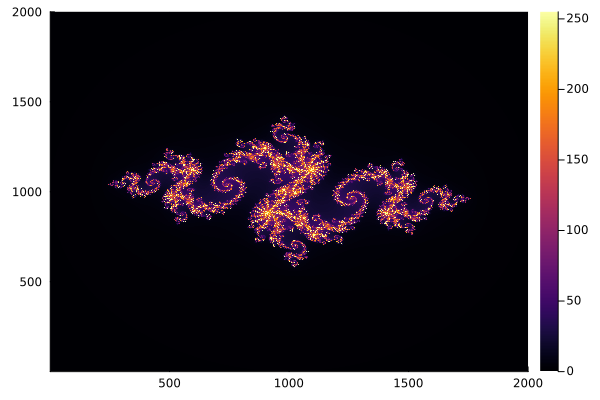

In [13]:
# 1)
"""
Computes the Julia set sequentially (column by column).
The result is written into `img`.
"""
function compute_juliaset_sequential!(img; kwargs...)
    # TODO
    n = size(img, 2)
    for j in 1:n
        _compute_column!(img, j; kwargs...)
    end
end

N = 2000
img = zeros(Int, N, N)
compute_juliaset_sequential!(img)
heatmap(img)

**Task 2:** Now implement a variant `compute_juliaset_threads!` that does the same as `compute_juliaset_sequential` but is multithreaded via `@threads`.

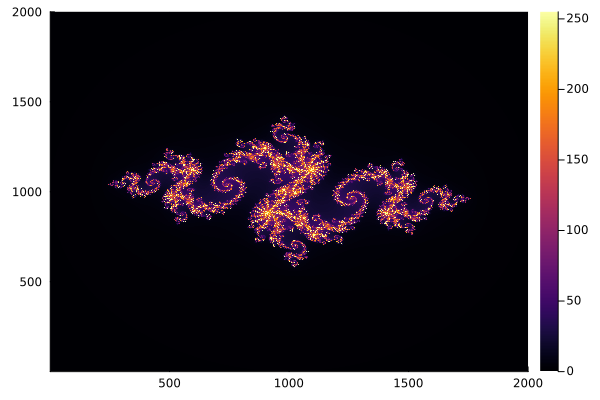

In [17]:
# 2)
"""
Computes the Julia set column by column using multithreading (`@threads`).
The result is written into `img`.
"""
function compute_juliaset_threads!(img; kwargs...)
    # TODO
    n = size(img, 2)
    @threads for j in 1:n
        _compute_column!(img, j; kwargs...)
    end
end

N = 2000
img = zeros(Int, N, N)
compute_juliaset_threads!(img)
heatmap(img)

**Task 3:** Now implement a variant `compute_juliaset_spawn!` that uses `@spawn` to multithread the computation. (Note: Don't forget to synchronize!)

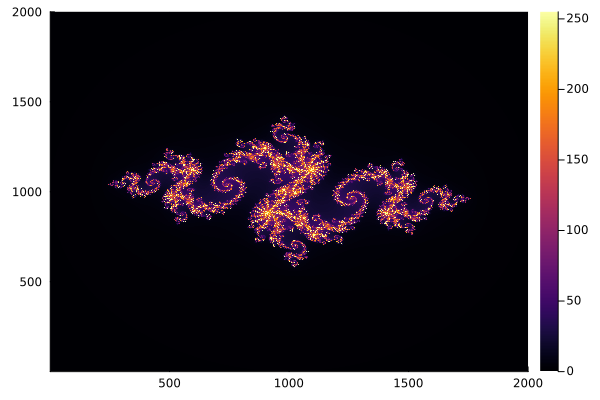

In [19]:
# 3)
"""
Computes the Julia set column by column using multithreading (`@spawn`).
The result is written into `img`.
"""
function compute_juliaset_spawn!(img; kwargs...)
    # TODO
    n = size(img, 2)
    @sync for j in 1:n
        @spawn _compute_column!(img, j; kwargs...)
    end
end

N = 2000
img = zeros(Int, N, N)
compute_juliaset_spawn!(img)
heatmap(img)

**Task 4:** Benchmark the three variants. Can you explain why the `@spawn` variant is faster than the version with `@threads`?

In [20]:
# 4)
N = 2000
img = zeros(Int, N, N)
# TODO
@btime compute_juliaset_sequential!($img);
@btime compute_juliaset_threads!($img);
@btime compute_juliaset_spawn!($img);

# Explanation:
# The key point is that the number of iterations per pixel (or column),
# and hence the computational cost, varies for different input points.
# The workload across the entire image is therefore **non-uniform**
# and can benefit from **load-balancing**.
# While `@threads` divides the work (close to) equally among threads
# `@spawn` gives a form of load-balancing and is thus the fastest.

  141.548 ms (0 allocations: 0 bytes)


  45.653 ms (37 allocations: 3.44 KiB)


  29.402 ms (10019 allocations: 1.03 MiB)
